In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

In [3]:
save_path = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/entangled_typicality/"
# Import metadata
meta = pd.read_json(f'{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json').T.reset_index().rename(columns={'index':'sku'})
# Import typicality scores and merge to metadata
typicality_scores = pickle.load(open(f"{save_path}/typicality_scores.pkl", "rb"))
typicality_scores = pd.Series(typicality_scores)
typicality_scores.index.name = 'sku'
typicality_scores.name = 'typicality_score'

meta = meta.merge(typicality_scores, on='sku')
meta.head(3)

sku                                               name  \
0  AN621C22S-O11                               Jersey dress - brown   
1  BU321C01G-K11                     Jersey dress - marine/bedruckt   
2  JY121C0TB-A11  JDYCARLA CATHINKA DRESS - Jersey dress - cloud...   

    sku_base sku_color_code  \
0  AN621C22S            O11   
1  BU321C01G            K11   
2  JY121C0TB            A11   

                                                 url       brand  \
0  https://en.zalando.de/anna-field-shift-dress-b...  Anna Field   
1  https://en.zalando.de/buffalo-jersey-dress-mar...     Buffalo   
2  https://en.zalando.de/jdy-carla-cathinka-dress...         JDY   

  original_price current_price                                  brand_url  \
0          39.99         39.99          https://en.zalando.de/anna-field/   
1          39.99         39.99             https://en.zalando.de/buffalo/   
2          34.99         34.99  https://en.zalando.de/jacqueline-de-yong/   

       category  ...          fit        neckline pattern           collar  \
0   Shift dress  ...     Slim Fit            None   Plain  Standing collar   
1  Jersey dress  ...  Regular Fit  Low-cut v-neck   Print             None   
2  Jersey dress  ...  Regular Fit       Crew neck   Plain  Standing collar   

        length         shape sleeve_length  \
0  Calf-length  Body-hugging         Short   
1  Knee-length        Fitted    Sleeveless   
2  Knee-length        Flared         Short   

                                       thumbnail_url  \
0  https://img01.ztat.net/article/spp-media-p1/fb...   
1  https://img01.ztat.net/article/spp-media-p1/50...   
2  https://img01.ztat.net/article/spp-media-p1/20...   

                                        packshot_url typicality_score  
0  https://img01.ztat.net/article/spp-media-p1/c8...         0.823655  
1  https://img01.ztat.net/article/spp-media-p1/17...         0.807152  
2  https://img01.ztat.net/article/spp-media-p1/20...         0.776698  

[3 rows x 23 columns]

### Helper Functions

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

In [6]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [7]:
def generate_pti(latent, G_PTI):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    img = tensor2im(gen.squeeze(0))
    return img

### Typicality Helper Functions

In [8]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Dino/")
from dino_utils import get_embedding
os.chdir(current_wd)

Using mps as device
Using mps as device
Using cpu as device


/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [9]:
# Get typicality morph
embeddings_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Embeddings/e4e_embeddings_from_saved.pt"
embeddings_dict = torch.load(embeddings_path)
embeddings = torch.stack(list(embeddings_dict.values())).squeeze(1)
morph = embeddings.mean(axis = 0)


def calculate_typicality(img:Image):
    #Save image to temp
    img.save('temp.jpg')
    # Calculate dino embedding 
    embedding = get_embedding('temp.jpg')
    os.remove('temp.jpg')
    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(embedding.squeeze(0), morph, dim=0)
    return similarity

### InterFaceGAN Helper Functions

In [10]:
def get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)

    boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")
    boundary = torch.tensor(boundary)
    for i in range(steps):
        latent_code[i, :, :] = latent_code[i, :, :] + linspace[i] * boundary
    
    return latent_code

In [11]:
def run_example(n, direction = 'more', steps=5, distance=15, sku = None):

    boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/entangled_typicality/{n}/"

    # Load in training stats
    training_stats = pd.read_csv(f"{boundaries_base_dir}summary_stats.csv")

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Sample one latent
    df = meta.copy()
    if sku:
        sample = df[df.sku == sku]
    else: 
        sample = df.sample(1)
        global chosen_sku
        chosen_sku = sample.sku.item()
    latent_code = latents[sample.sku.item()].squeeze(0).flatten()

    # Generate Interpolations
    if direction == 'more': 
        start_distance, end_distance = 0, distance
    elif direction == 'less': 
        start_distance, end_distance = 0,  -distance

    interpolations = get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir)

    imgs = [generate_from_latent(interpolations[i, :, :].squeeze(0).reshape(1,16,512)) for i in range(steps)]
    # Calculate typicality scores of generated images
    scores = [calculate_typicality(img) for img in imgs]

    fig, ax = plt.subplots(1, steps, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
        ax[i].set_title(f"Steps: {np.linspace(start_distance, end_distance, steps)[i]} | Typicality: {np.round(scores[i].item(), 2)}")

    
    fig.suptitle(f"SKU: {sample.sku.item()}\nDirection: {direction} typical\nBoundary Acc: {np.round(training_stats.acc.item(), 2)}")
    plt.show()

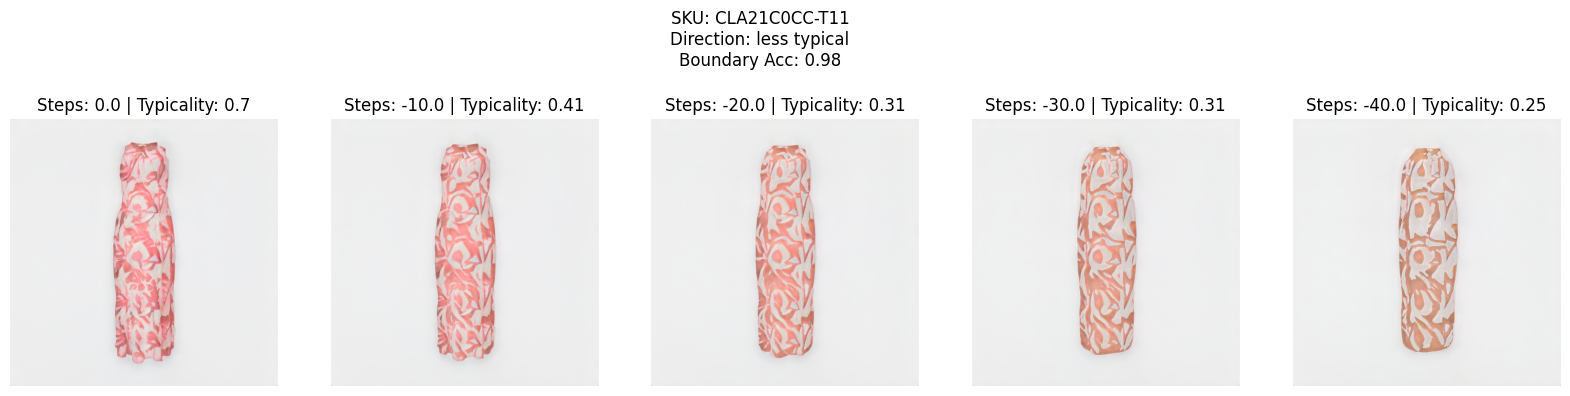

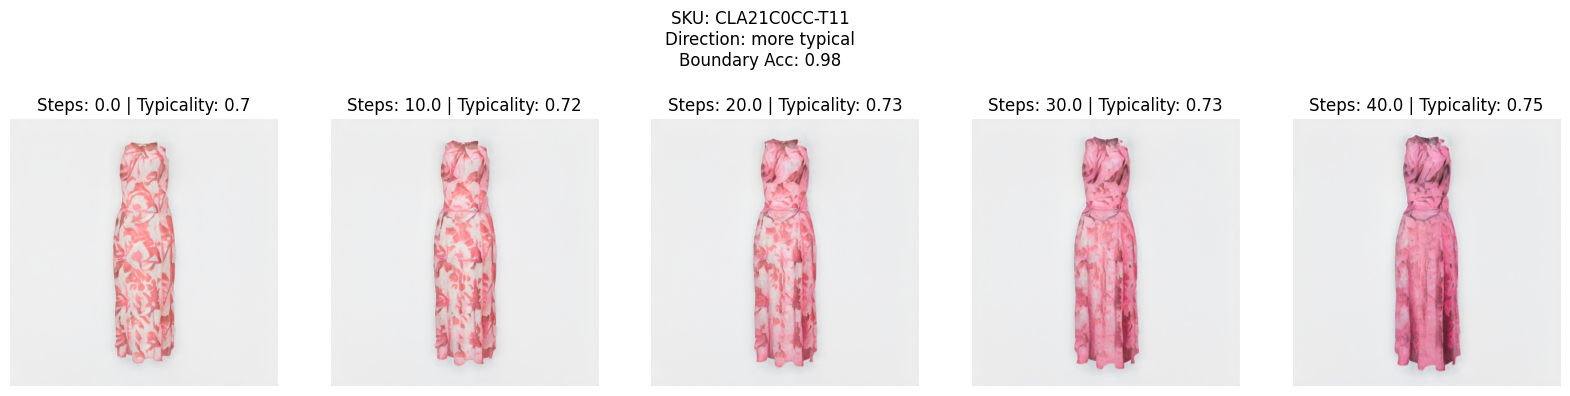

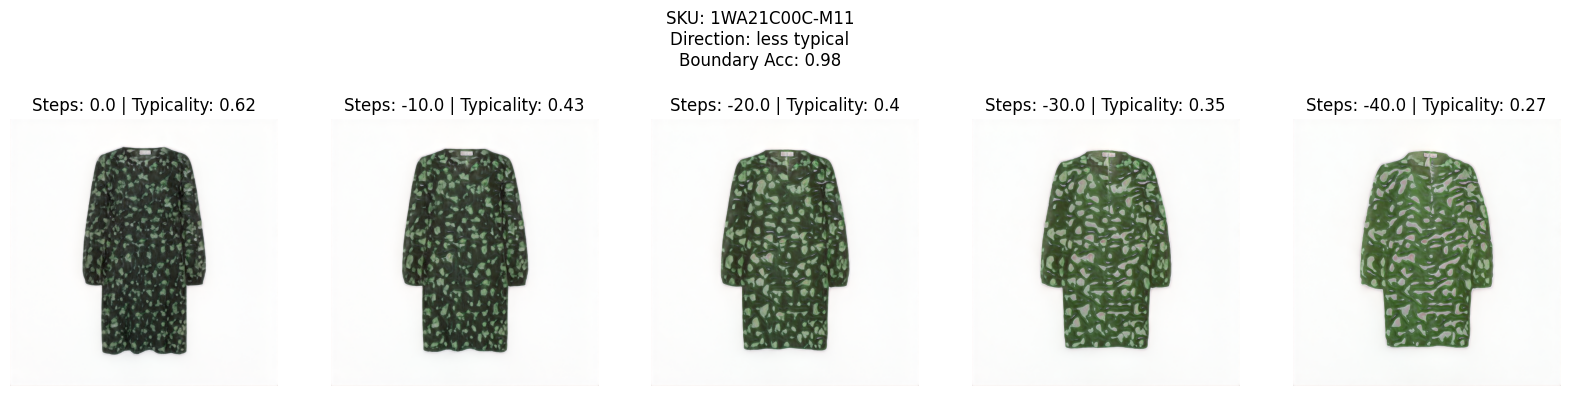

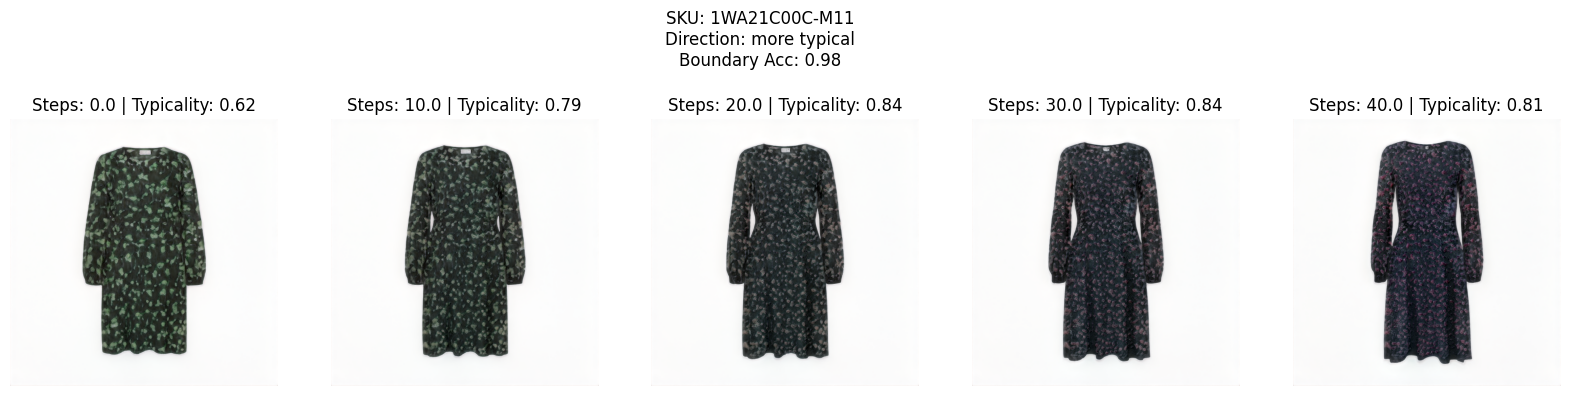

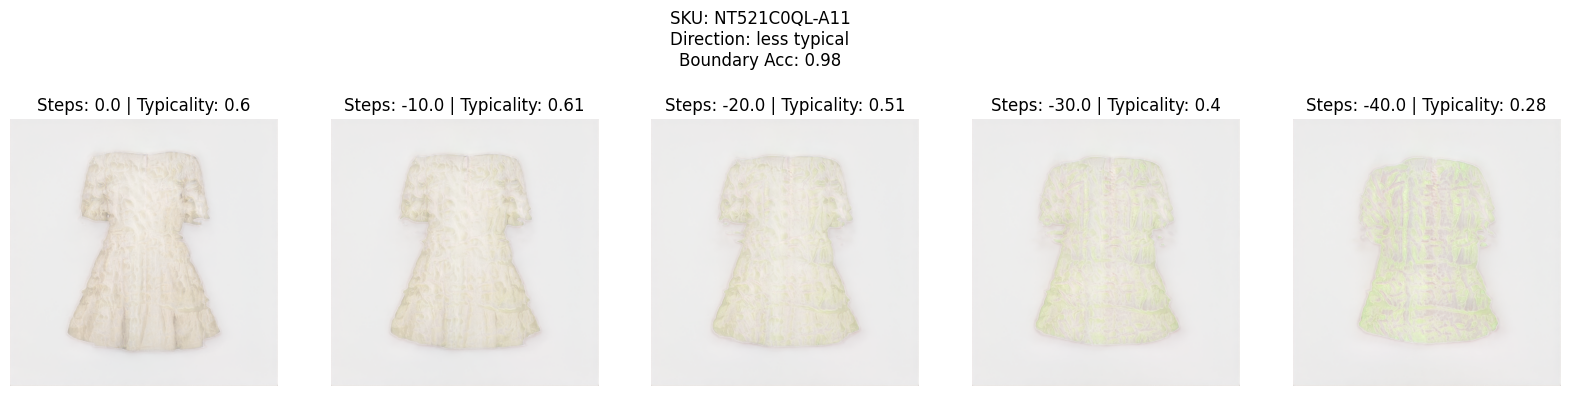

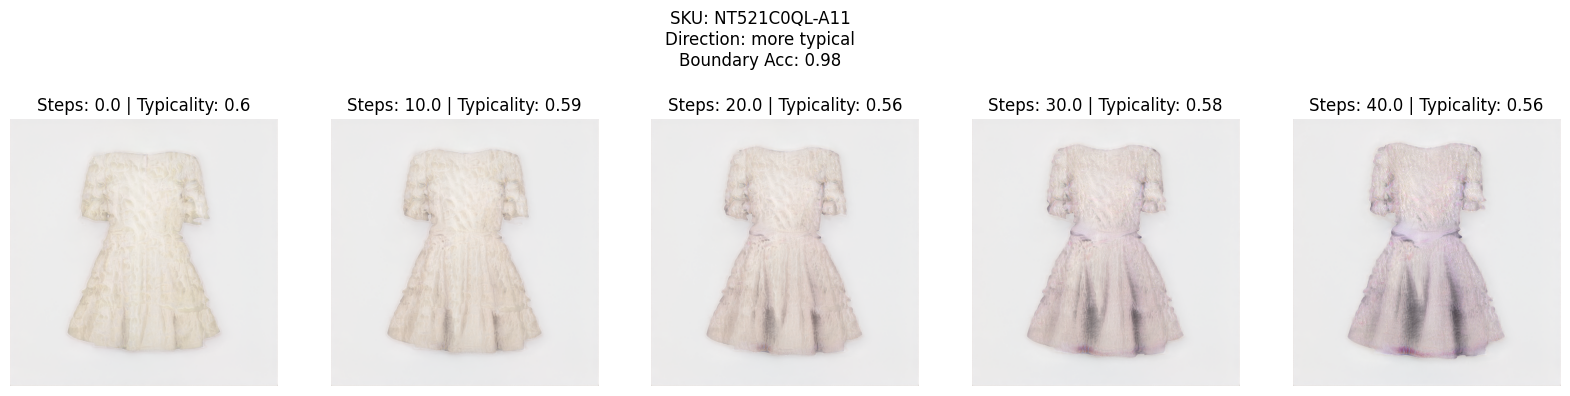

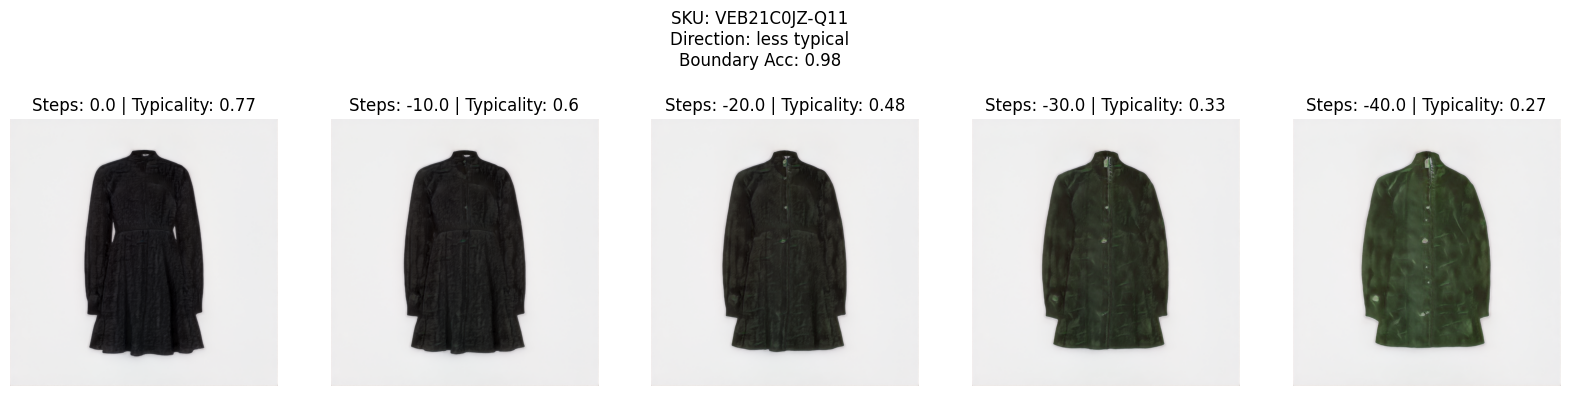

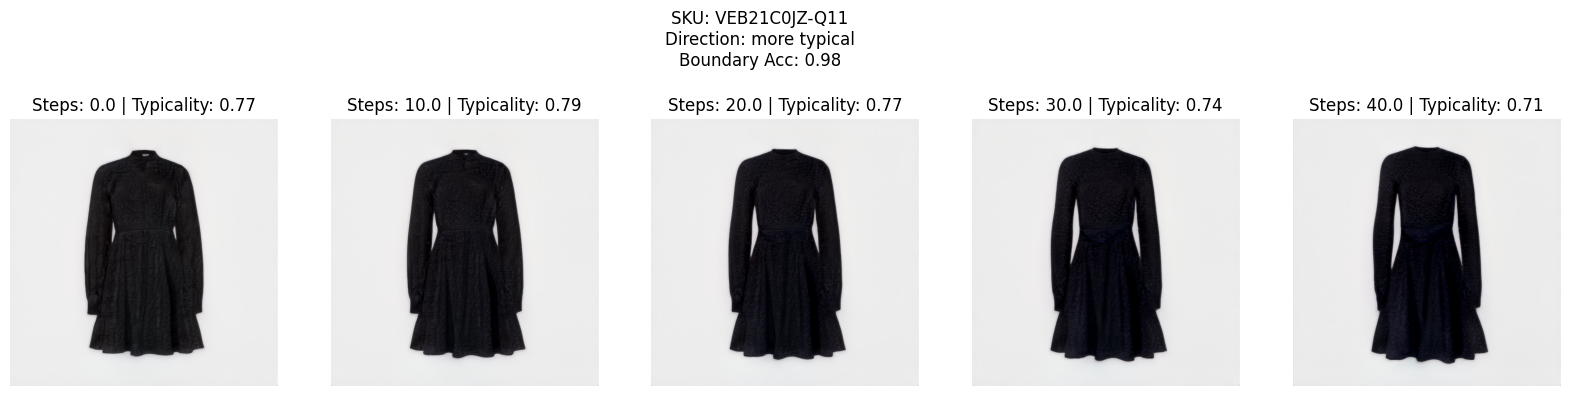

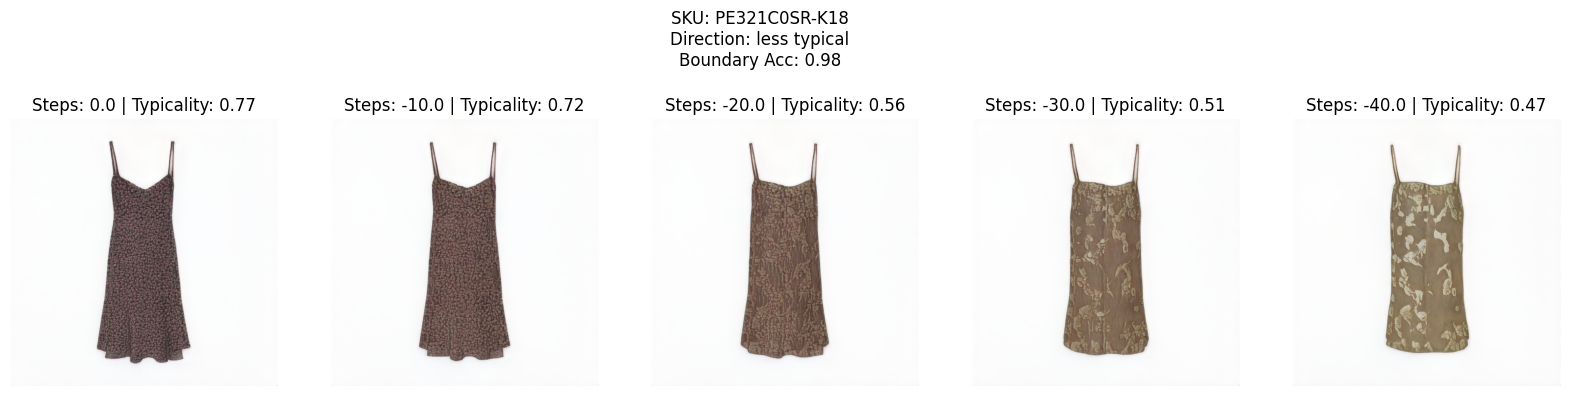

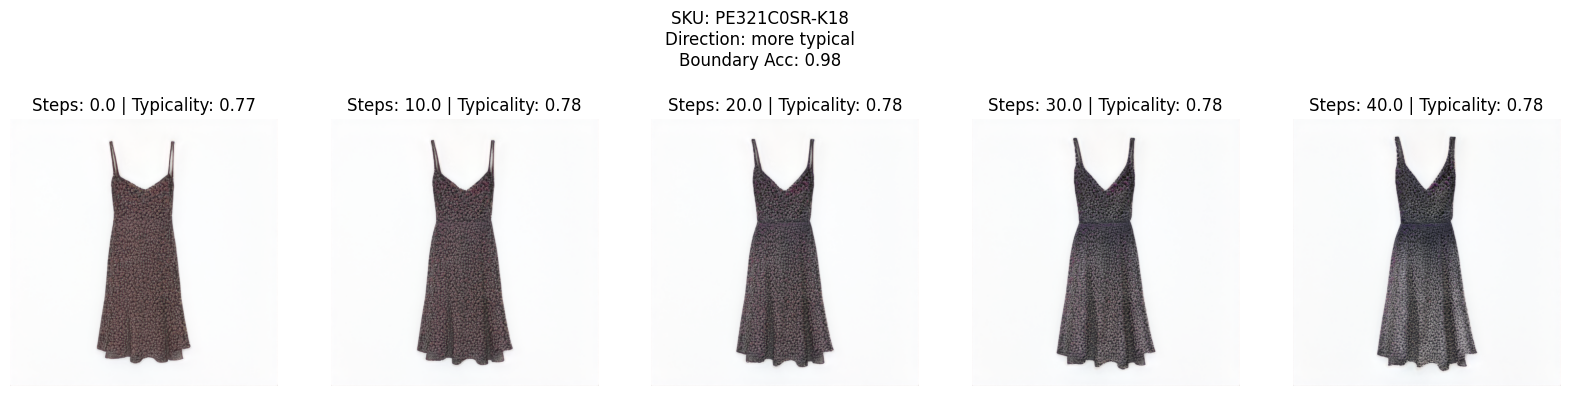

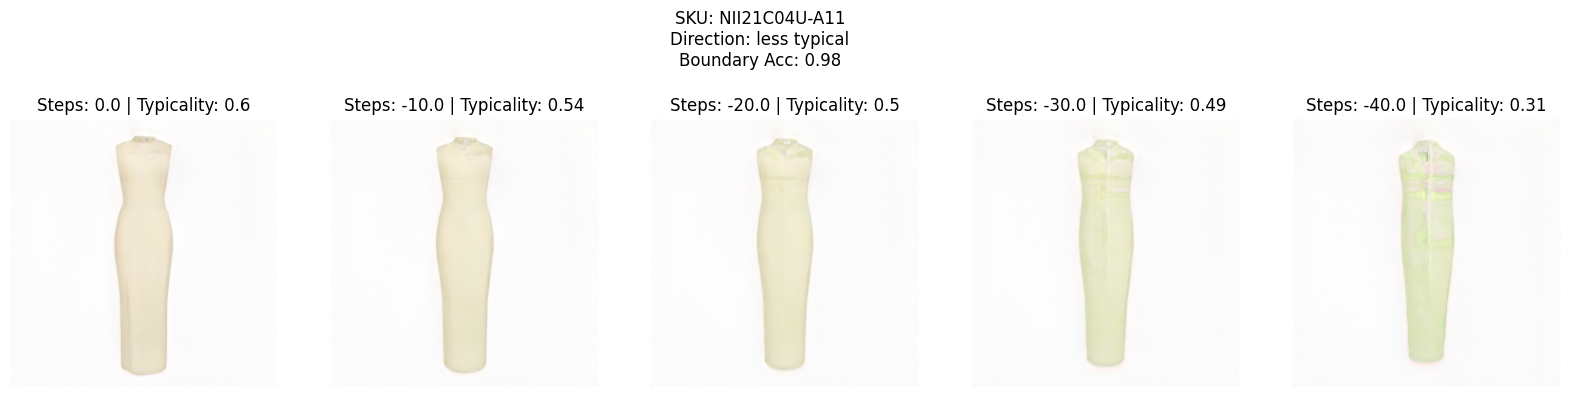

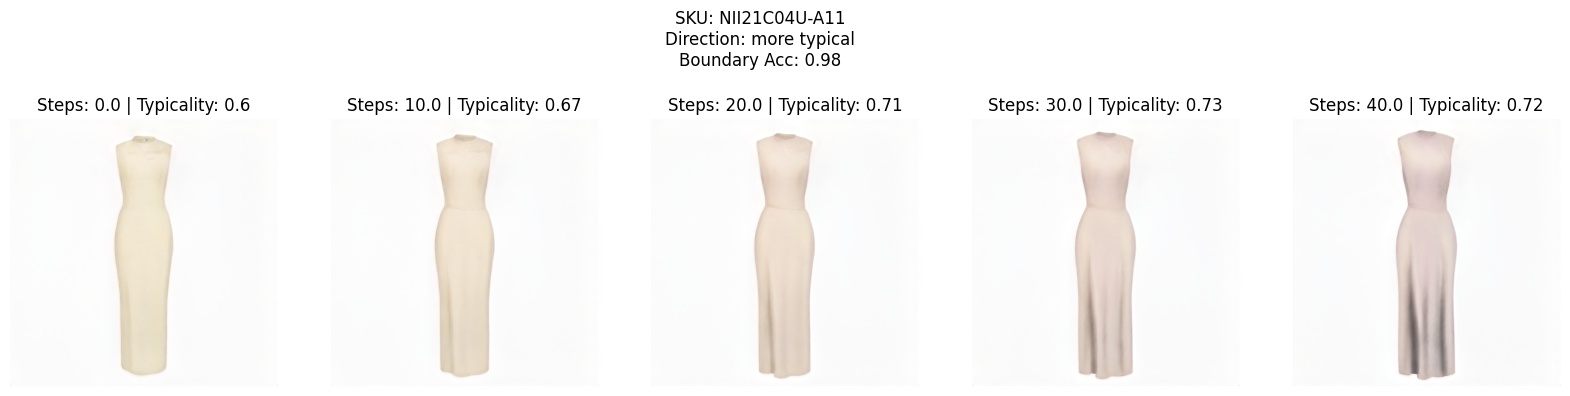

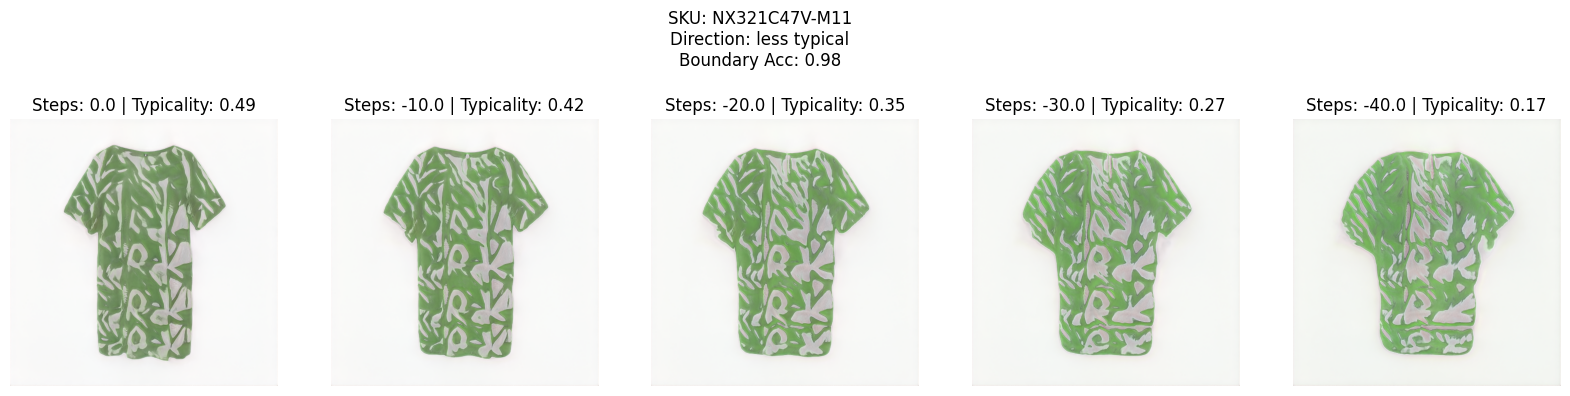

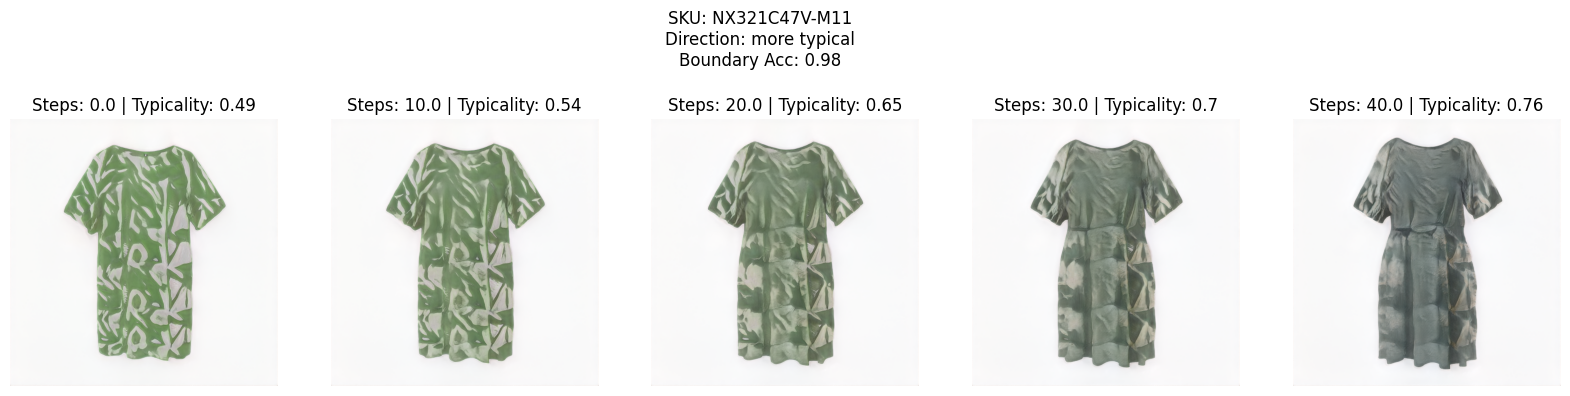

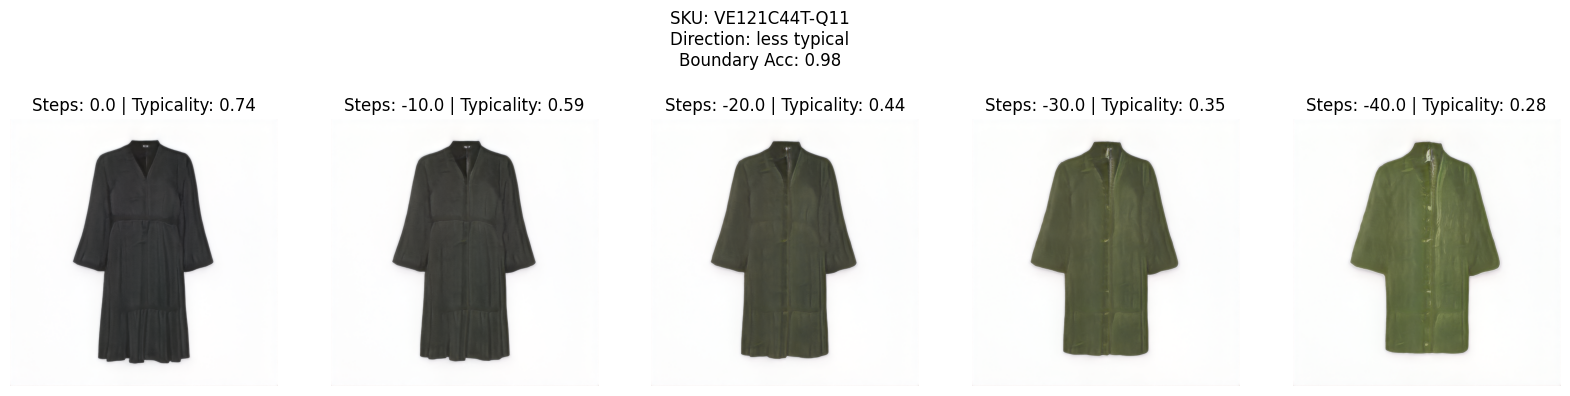

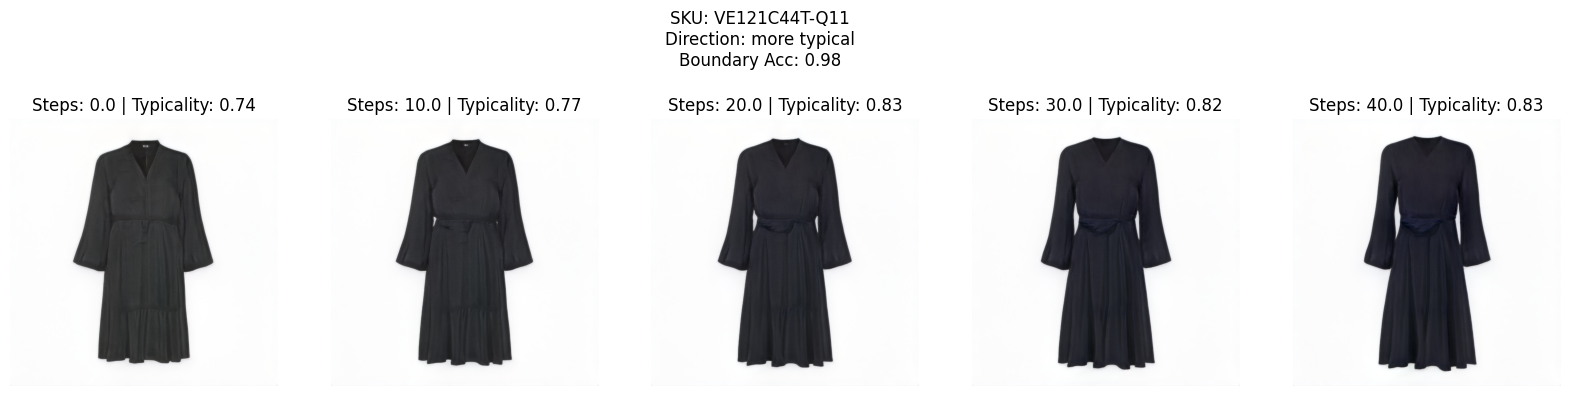

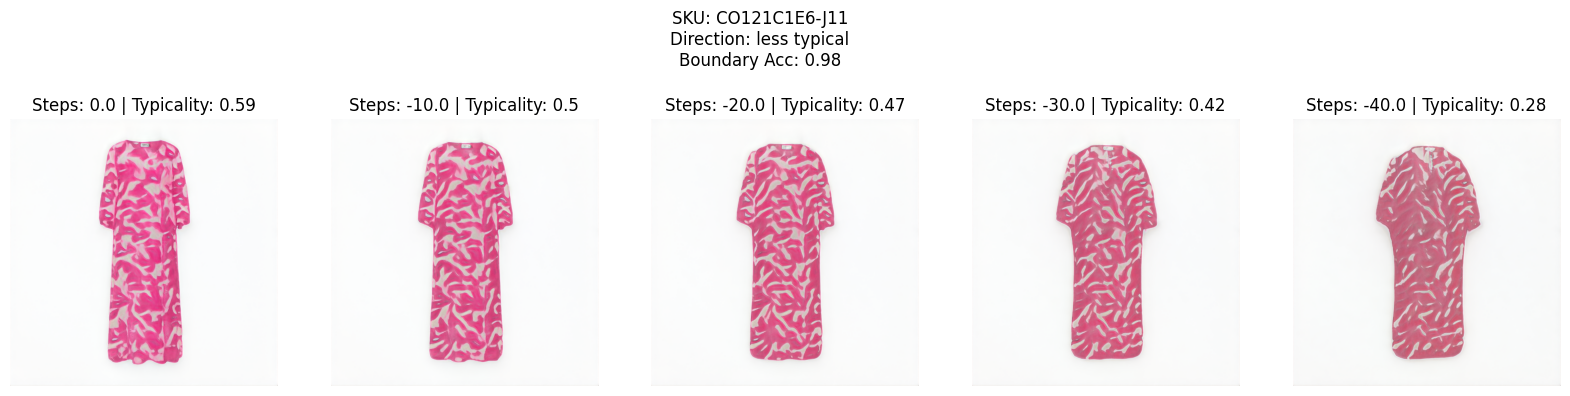

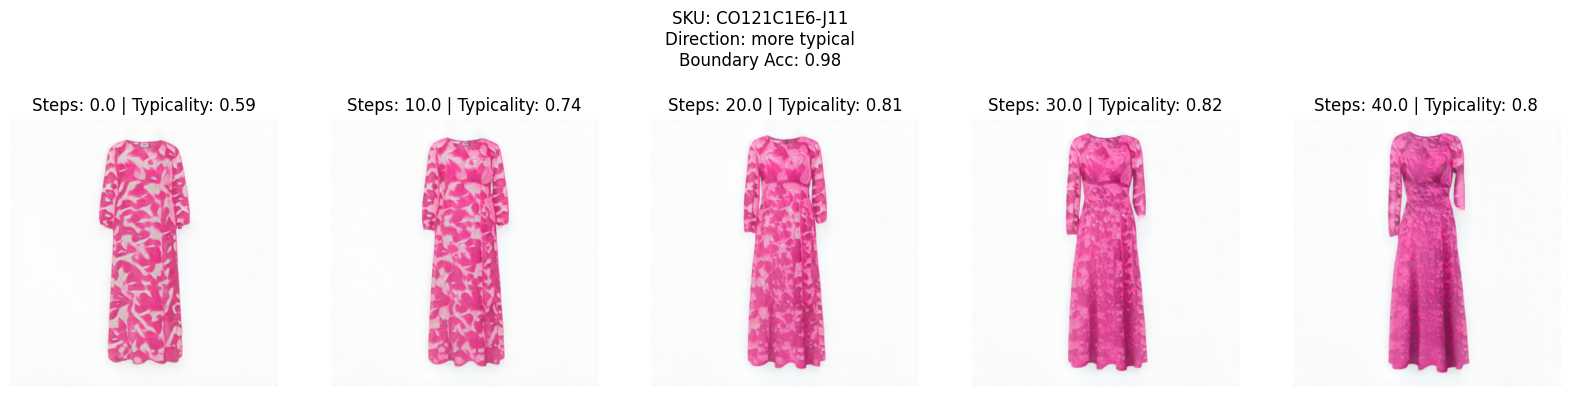

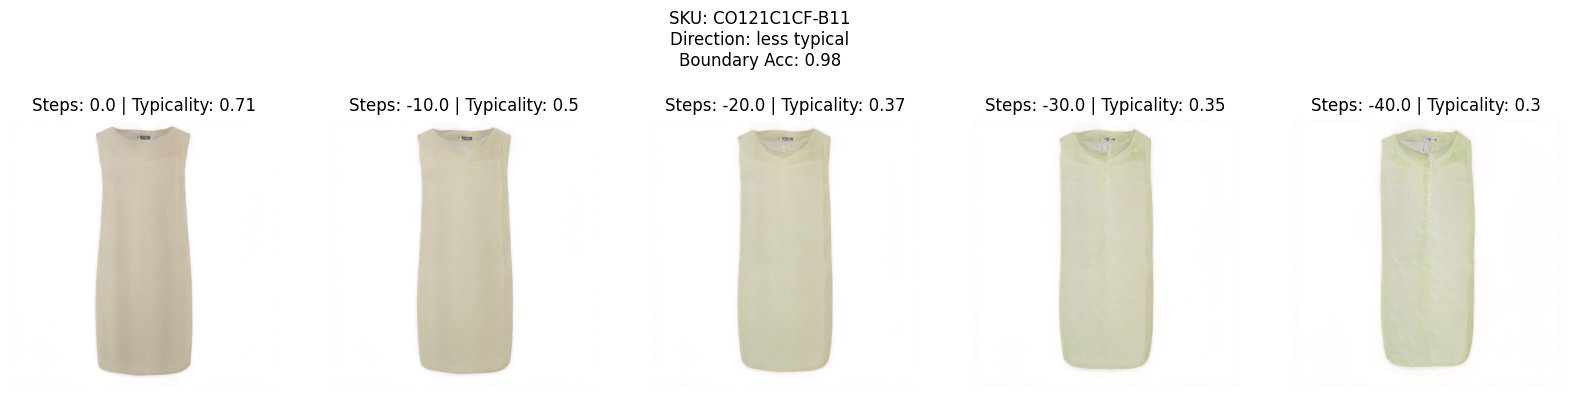

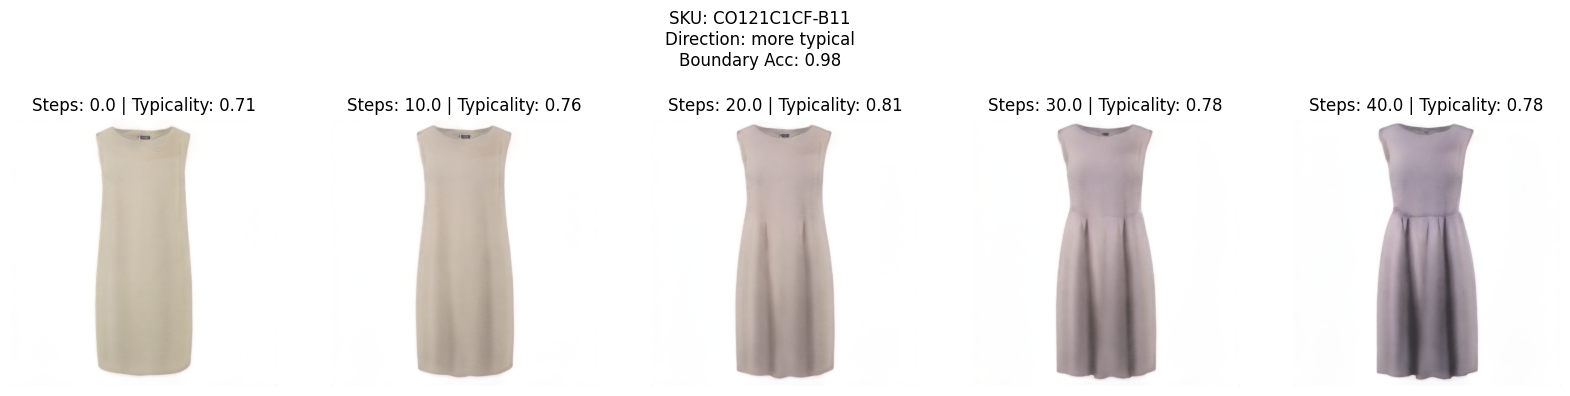

In [12]:
for _ in range(10):
    run_example(n = 1000, direction = 'less', steps=5, distance=40)
    run_example(n = 1000, direction = 'more', steps=5, distance=40, sku = chosen_sku)